# User defined equations of state

In this notebook, we will give an example of how to implement a new equation of state within `Clapeyron.jl`. In this case, it will be the SAFT-VR Mie+AT model developed by Walker _et al._ which is simply a modification of the regular SAFT-VR Mie equation of state. 

The first step is to call `Clapeyron.jl` as one normally would only this time importing a few additional functions which we would like to modify:

In [12]:
using Pkg
Pkg.activate("..")
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot
import Clapeyron: SAFTVRMieModel, @f, @newmodel, AssocOptions, has_sites, has_groups, N_A
import Clapeyron: a_res, a_disp, a_hs, d, B, aS_1, KHS, f123456, Cλ, ∑, data

The next step is to define the parameter object for our equation of state. This is all the parameters we will need within the equation. The parameter type will also need to be defined (`SingleParam` for those parameters which only depend on a single species and `PairParam` for those which depend on two species):

In [2]:
struct SAFTVRMieATParam <: EoSParam
    segment::SingleParam{Float64}
    sigma::PairParam{Float64}
    lambda_a::PairParam{Float64}
    lambda_r::PairParam{Float64}
    epsilon::PairParam{Float64}
    Mw::SingleParam{Float64}
    nu::SingleParam{Float64}
end

The next step is to define the model type. Since SAFT-VR Mie+AT re-uses many of the same functions as SAFT-VR Mie, we define the `SAFTVRMieATModel` as a sub-type of `SAFTVRMieModel`. This effectively means we only need to re-define those functions which are different between the two equations:

In [3]:
abstract type SAFTVRMieATModel <: SAFTVRMieModel end

We then create the model using the `@newmodel` macro:

In [4]:
@newmodel SAFTVRMieAT SAFTVRMieATModel SAFTVRMieATParam
export SAFTVRMieAT

The next function that needs to be built is the model constructor (here called `SAFTVRMieAT`). This involves a few different components:

In [5]:
# Although optional, there should be some additional argument if the user would like to modify certain aspects of the model, such as the ideal model used
function SAFTVRMieAT(components; 
                     idealmodel=BasicIdeal, 
                     userlocations=String[], 
                     ideal_userlocations=String[], 
                     verbose=false)
    
    # The next step is to collect all the parameters from the csv files. The getparams function can handle this. 
    # It is also useful to allow for custom userlocations to be fed into this function
    params = Clapeyron.getparams(components, ["properties/molarmass.csv"]; userlocations=append!(userlocations,ideal_userlocations), verbose=verbose)

    # The next step is to transform the parameters from the database into the form in which they are useable within the equation of state (e.g. applying combining rules)
    params["Mw"].values .*= 1E-3
    Mw = params["Mw"]
    segment = params["m"]
    nu = params["nu"]
    params["sigma"].values .*= 1E-10
    sigma = Clapeyron.sigma_LorentzBerthelot(params["sigma"])
    epsilon = Clapeyron.epsilon_HudsenMcCoubrey(params["epsilon"], sigma)
    lambda_a = Clapeyron.lambda_LorentzBerthelot(params["lambda_a"])
    lambda_r = Clapeyron.lambda_LorentzBerthelot(params["lambda_r"])

    # The struct with all of our parameters is then formed
    packagedparams = SAFTVRMieATParam(segment, sigma, lambda_a, lambda_r, epsilon, Mw, nu)
    
    # If the model is based on an existing one, it's generally a good idea to add the reference DOI here
    references = [""]

    # We then construct and return the model
    model = SAFTVRMieAT(packagedparams, idealmodel;ideal_userlocations=ideal_userlocations, references=references, verbose=verbose)
    return model
end

SAFTVRMieAT

The next step involves writing down the equations used within the equation of state. At the end of the day, the output should be `a_res`, the reduced residual Helmholtz free energy:

In [10]:
function d(model::SAFTVRMieATModel, V, T, z)
    ρ  = N_A*sum(z)/V
    λ  = 0.85
    ν  = model.params.nu.values
    ϵ = model.params.epsilon.diagvalues
    σ = model.params.sigma.diagvalues
    λr = model.params.lambda_r.diagvalues
    λa = model.params.lambda_a.diagvalues
    return d.(model,V,T,Ref(z),λa,λr,ϵ,σ,ν,ρ,λ)
end

function d(model::SAFTVRMieATModel, V, T, z, λa,λr,ϵ,σ,ν,ρ,λ)
    u = Clapeyron.SAFTVRMieconsts.u
    w = Clapeyron.SAFTVRMieconsts.w
    θ = @f(Clapeyron.Cλ,λa,λr)*ϵ/T*(1-ρ*λ*ν*σ^3)
    σ*(1-∑(w[j]*(θ/(θ+u[j]))^(1/λr)*(exp(θ*(1/(θ/(θ+u[j]))^(λa/λr)-1))/(u[j]+θ)/λr) for j ∈ 1:5))
end

function a_disp(model::SAFTVRMieATModel, V, T, z,_data = @f(data))
    _d,ρS,ζi,_ζ_X,_ζst,_ = _data
    comps = @Clapeyron.comps
    l = length(comps)
    ∑z = ∑(z)
    m = model.params.segment.values
    _ϵ = model.params.epsilon.values
    _λr = model.params.lambda_r.values
    _λa = model.params.lambda_a.values
    _σ = model.params.sigma.values
    _ν = model.params.nu.values
    m̄ = Clapeyron.dot(z, m)
    m̄inv = 1/m̄
    a₁ = zero(V+T+first(z))
    a₂ = a₁
    a₃ = a₁
    _ζst5 = _ζst^5
    _ζst8 = _ζst^8
    _KHS = @f(KHS,_ζ_X,ρS)
    
    ρ  = N_A*sum(z)/V
    λ  = 0.85
    for i ∈ comps
        j = i
        x_Si = z[i]*m[i]*m̄inv
        x_Sj = x_Si
        ϵ = _ϵ[i,j]
        λa = _λa[i,i]
        λr = _λr[i,i] 
        σ = _σ[i,i]
        ν  = _ν[i]
        AT_corr = (1-ρ*λ*ν*σ^3)
        _C = @f(Cλ,λa,λr)
        dij = _d[i]
        dij3 = dij^3
        x_0ij = σ/dij
        #calculations for a1 - diagonal
        aS_1_a = @f(aS_1,λa,_ζ_X)
        aS_1_r = @f(aS_1,λr,_ζ_X)
        B_a = @f(B,λa,x_0ij,_ζ_X)
        B_r = @f(B,λr,x_0ij,_ζ_X)
        a1_ij = (2*π*AT_corr*ϵ*dij3)*_C*ρS*
        (x_0ij^λa*(aS_1_a+B_a) - x_0ij^λr*(aS_1_r+B_r))

        #calculations for a2 - diagonal
        aS_1_2a = @f(aS_1,2*λa,_ζ_X)
        aS_1_2r = @f(aS_1,2*λr,_ζ_X)
        aS_1_ar = @f(aS_1,λa+λr,_ζ_X)
        B_2a = @f(B,2*λa,x_0ij,_ζ_X)
        B_2r = @f(B,2*λr,x_0ij,_ζ_X)
        B_ar = @f(B,λr+λa,x_0ij,_ζ_X)
        α = _C*(1/(λa-3)-1/(λr-3))
        f1,f2,f3,f4,f5,f6 = @f(f123456,α)
        _χ = f1*_ζst+f2*_ζst5+f3*_ζst8
        a2_ij = π*_KHS*(1+_χ)*ρS*AT_corr^2*ϵ^2*dij3*_C^2 *
        (x_0ij^(2*λa)*(aS_1_2a+B_2a)
        - 2*x_0ij^(λa+λr)*(aS_1_ar+B_ar)
        + x_0ij^(2*λr)*(aS_1_2r+B_2r))
        
        #calculations for a3 - diagonal
        a3_ij = -ϵ^3*AT_corr^3*f4*_ζst * exp(f5*_ζst+f6*_ζst^2)
        #adding - diagonal
        a₁ += a1_ij*x_Si*x_Si
        a₂ += a2_ij*x_Si*x_Si
        a₃ += a3_ij*x_Si*x_Si
    end
    a₁ = a₁*m̄/T/∑z
    a₂ = a₂*m̄/(T*T)/∑z
    a₃ = a₃*m̄/(T*T*T)/∑z
    #@show (a₁,a₂,a₃)
    adisp =  a₁ + a₂ + a₃ 
    return adisp
end

function a_res(model::SAFTVRMieATModel, V, T, z)
    _data = @f(data)
    return @f(a_hs,_data)+@f(a_disp,_data)
end

a_res (generic function with 24 methods)

With that, the equation is built and ready to use! As an example:

In [22]:
species = ["He_JHBV","Ne_JHBV","Ar_JHBV","Kr_JHBV","Xe_JHBV"]

model = SAFTVRMieAT.(species;userlocations=["Ab_initio_SAFT.csv"],
                                ideal_userlocations=["Ab_initio_SAFT_molarmass.csv"]);

5-element Vector{SAFTVRMieAT{BasicIdeal}}:
 SAFTVRMieAT{BasicIdeal}("He_JHBV")
 SAFTVRMieAT{BasicIdeal}("Ne_JHBV")
 SAFTVRMieAT{BasicIdeal}("Ar_JHBV")
 SAFTVRMieAT{BasicIdeal}("Kr_JHBV")
 SAFTVRMieAT{BasicIdeal}("Xe_JHBV")

We can then obtain critical and saturation properties, and plot the results:

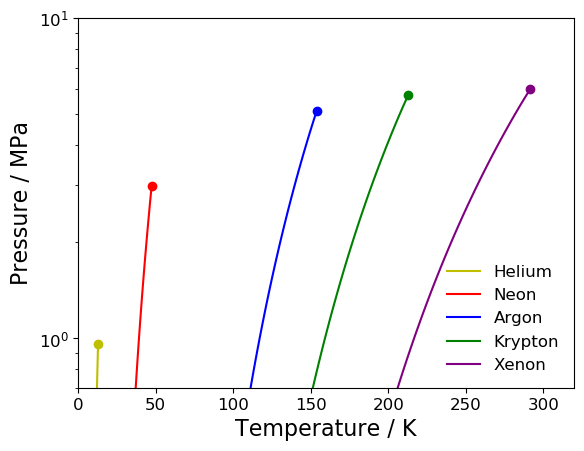

([0.01, 0.1, 1.0, 10.0, 100.0], PyObject[PyObject Text(0, 0.01, '$\\mathdefault{10^{-2}}$'), PyObject Text(0, 0.1, '$\\mathdefault{10^{-1}}$'), PyObject Text(0, 1.0, '$\\mathdefault{10^{0}}$'), PyObject Text(0, 10.0, '$\\mathdefault{10^{1}}$'), PyObject Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

In [33]:
label=["Helium","Neon","Argon","Krypton","Xenon"]
color=["y","r","b","g","purple"]

crit=crit_pure.(model);

for i ∈ 1:5
    T = range(0.7*crit[i][1],crit[i][1],length=100)

    sat = saturation_pressure.(model[i],T)

    p = [sat[i][1] for i ∈ 1:100]
    v_l = [sat[i][2] for i ∈ 1:100]
    v_v = [sat[i][3] for i ∈ 1:100]
    plt.semilogy(T,p./1e6,color=color[i],label=label[i])
    plt.plot(crit[i][1],crit[i][2]./1e6,marker="o",color=color[i])
end
plt.ylim([0.7,1e1])
plt.xlim([0,320])
plt.legend(loc="lower right",frameon=false,fontsize=12) 
plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Pressure / MPa",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)